In [23]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.special import inv_boxcox

import re

In [24]:
fifa_data = pd.read_csv('fifa21_male2.csv')
fifa_data.columns

Index(['ID', 'Name', 'Age', 'OVA', 'Nationality', 'Club', 'BOV', 'BP',
       'Position', 'Player Photo',
       ...
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'GK', 'Gender'],
      dtype='object', length=107)

## 1. choosing the columns we want

In [25]:
data = fifa_data[['ID',
 'Name',
 'Age',
 'OVA',
 'BOV',
 'POT',
 'Growth',
 'Value',
 'Total Stats',
 'Base Stats',
 'Composure',
 'Stamina',
 'Strength',
 'Power',
 'Reactions']]
data

,ID,Name,Age,OVA,BOV,POT,Growth,Value,Total Stats,Base Stats,Composure,Stamina,Strength,Power,Reactions
0,2,G. Pasquale,33,69,71,69,0,€625K,1929,408,NaN,69,68,347,69
1,16,Luis García,37,71,70,71,0,€600K,1906,385,79.0,64,60,324,65
2,27,J. Cole,33,71,71,71,0,€1.1M,1770,354,NaN,29,56,284,59
3,36,D. Yorke,36,68,70,82,14,€0,1348,369,NaN,51,66,239,55
4,41,Iniesta,36,81,82,81,0,€5.5M,2014,420,89.0,58,62,297,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17120,259088,A. Medioub,22,64,66,69,5,€550K,1367,302,46.0,59,74,279,48
17121,259090,W. Rickard,18,56,58,66,10,€130K,1529,319,46.0,53,57,271,54
17122,259091,C. Barrett,18,56,56,67,11,€130K,1430,303,43.0,53,54,233,59
17123,259101,J. Gazibegović,20,62,62,73,11,€475K,1579,335,54.0,57,48,261,56


# Standardizing

In [26]:
def cleaning_0(data): 
    cols = [col_name.lower().replace(' ', '_') for col_name in data.columns]
    data.columns = cols
    question1 = input("Are there columns to drop? (Y/N)")
    while question1 == "Y":
        which_one = input("Enter column to drop (None: script runs further):")
        if which_one != "None":
            data = data.drop([which_one], axis=1)
            question2 = input("Are there more columns to drop? (Y/N)")
            if question2 == "Y":
                question1 = question2
            elif question2 == "N":
                print("No more columns dropped.")
                break
            else:
                print("Error: input must be Y or N!")
                question2 = input("Are there more columns to drop? (Y/N)")   
        elif which_one == "None":
            break   
    if question1 == "N":
        print("No columns dropped.")
    elif question1 != "Y" and question1 != "N":
        print("Error: input must be Y or N!")
        question1 = input("Are there columns to drop? (Y/N)")
        while question1 == "Y":
            which_one = input("Enter column to drop (None: continue without dropping or random key: repeat question):")
            if which_one == "None":
                break
            elif which_one != "None":
                data = data.drop([which_one], axis=1)
                question2 = input("Are there more columns to drop? (Y/N)")
                if question2 == "Y":
                    question1 = question2
                elif question2 == "N":
                    print("No more columns dropped.")
                    break
                else:
                    print("Error: input must be Y or N!")
                    question2 = input("Are there more columns to drop? (Y/N)")
        if question1 == "N":
            print("No columns dropped.")
        elif question1 != "Y" and question1 != "N":
            ("Error: input must be Y or N! To drop columns re-run function. Standardisation nevertheless complete")
            question1 = input("Are there columns to drop? (Y/N)")
    return data

In [27]:
cleaning_0(data)        # I removed the command for alphabetical order from my function, because it was harder to read the data with it

No more columns dropped.


,age,ova,bov,pot,growth,value,total_stats,base_stats,composure,stamina,strength,power,reactions
0,33,69,71,69,0,€625K,1929,408,NaN,69,68,347,69
1,37,71,70,71,0,€600K,1906,385,79.0,64,60,324,65
2,33,71,71,71,0,€1.1M,1770,354,NaN,29,56,284,59
3,36,68,70,82,14,€0,1348,369,NaN,51,66,239,55
4,36,81,82,81,0,€5.5M,2014,420,89.0,58,62,297,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17120,22,64,66,69,5,€550K,1367,302,46.0,59,74,279,48
17121,18,56,58,66,10,€130K,1529,319,46.0,53,57,271,54
17122,18,56,56,67,11,€130K,1430,303,43.0,53,54,233,59
17123,20,62,62,73,11,€475K,1579,335,54.0,57,48,261,56


In [28]:
num = data.select_dtypes(include = np.number)
num

,id,age,ova,bov,pot,growth,total_stats,base_stats,composure,stamina,strength,power,reactions
0,2,33,69,71,69,0,1929,408,NaN,69,68,347,69
1,16,37,71,70,71,0,1906,385,79.0,64,60,324,65
2,27,33,71,71,71,0,1770,354,NaN,29,56,284,59
3,36,36,68,70,82,14,1348,369,NaN,51,66,239,55
4,41,36,81,82,81,0,2014,420,89.0,58,62,297,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17120,259088,22,64,66,69,5,1367,302,46.0,59,74,279,48
17121,259090,18,56,58,66,10,1529,319,46.0,53,57,271,54
17122,259091,18,56,56,67,11,1430,303,43.0,53,54,233,59
17123,259101,20,62,62,73,11,1579,335,54.0,57,48,261,56


In [29]:
# a fast way to produce a heatmap

def fast_heatmap(data):
    mask = np.zeros_like(data.corr())
    mask[np.triu_indices_from(mask)] = True 
    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(data.corr(), mask=mask, annot=True)
    return ax

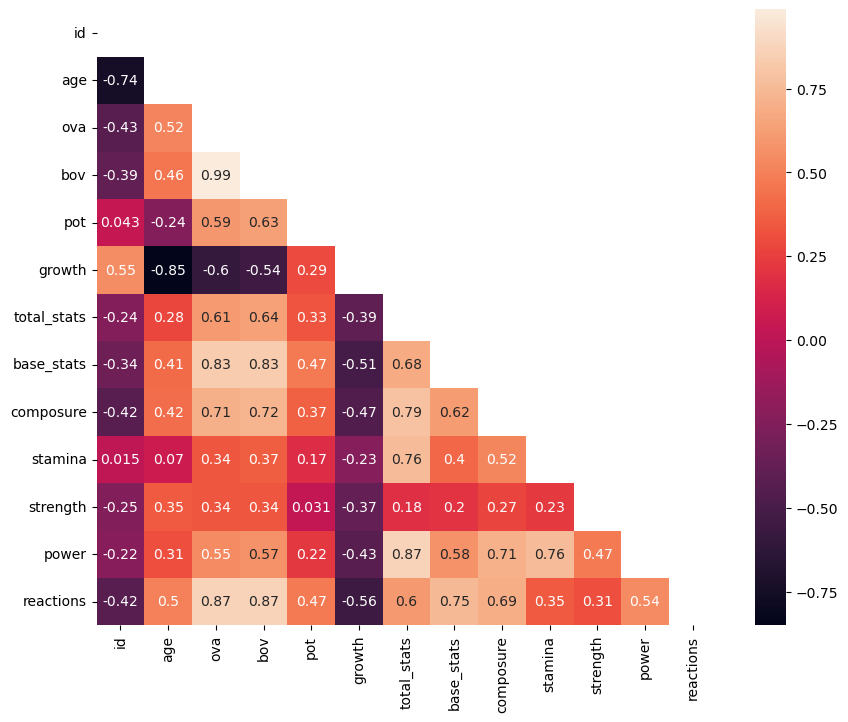

In [30]:
v = fast_heatmap(num)
plt.show(v)

In [31]:
cleaning_0(num)

No columns dropped.


,id,age,ova,bov,pot,growth,total_stats,base_stats,composure,stamina,strength,power,reactions
0,2,33,69,71,69,0,1929,408,NaN,69,68,347,69
1,16,37,71,70,71,0,1906,385,79.0,64,60,324,65
2,27,33,71,71,71,0,1770,354,NaN,29,56,284,59
3,36,36,68,70,82,14,1348,369,NaN,51,66,239,55
4,41,36,81,82,81,0,2014,420,89.0,58,62,297,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17120,259088,22,64,66,69,5,1367,302,46.0,59,74,279,48
17121,259090,18,56,58,66,10,1529,319,46.0,53,57,271,54
17122,259091,18,56,56,67,11,1430,303,43.0,53,54,233,59
17123,259101,20,62,62,73,11,1579,335,54.0,57,48,261,56


In [33]:
# Xisca's idea

def symb_to_num(x):
    if x[len(x)-1] == "K":
        return 1000
    if x[len(x)-1] == "M":
        return 1000000
    else:
        return 1


In [43]:
data1 = data.copy()

In [44]:
data1['value'] = data1['value'].str.replace('€', '')
data1['factors'] = data1['value'].apply(lambda x: symb_to_num(x)) # Xisca's idea
data1['value'] = data1['value'].str.replace('M', '')
data1['value'] = data1['value'].str.replace('K', '')
data1['value'] = data1['value'].apply(lambda x: float(x))
data1['value'] = data1['value'] * data1['factors']
data1 = data1.drop(['factors'], axis = 1)
data1

,id,name,age,ova,bov,pot,growth,value,total_stats,base_stats,composure,stamina,strength,power,reactions
0,2,G. Pasquale,33,69,71,69,0,625000.0,1929,408,NaN,69,68,347,69
1,16,Luis García,37,71,70,71,0,600000.0,1906,385,79.0,64,60,324,65
2,27,J. Cole,33,71,71,71,0,1100000.0,1770,354,NaN,29,56,284,59
3,36,D. Yorke,36,68,70,82,14,0.0,1348,369,NaN,51,66,239,55
4,41,Iniesta,36,81,82,81,0,5500000.0,2014,420,89.0,58,62,297,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17120,259088,A. Medioub,22,64,66,69,5,550000.0,1367,302,46.0,59,74,279,48
17121,259090,W. Rickard,18,56,58,66,10,130000.0,1529,319,46.0,53,57,271,54
17122,259091,C. Barrett,18,56,56,67,11,130000.0,1430,303,43.0,53,54,233,59
17123,259101,J. Gazibegović,20,62,62,73,11,475000.0,1579,335,54.0,57,48,261,56


In [45]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17125 entries, 0 to 17124
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           17125 non-null  int64  
 1   name         17125 non-null  object 
 2   age          17125 non-null  int64  
 3   ova          17125 non-null  int64  
 4   bov          17125 non-null  int64  
 5   pot          17125 non-null  int64  
 6   growth       17125 non-null  int64  
 7   value        17125 non-null  float64
 8   total_stats  17125 non-null  int64  
 9   base_stats   17125 non-null  int64  
 10  composure    16702 non-null  float64
 11  stamina      17125 non-null  int64  
 12  strength     17125 non-null  int64  
 13  power        17125 non-null  int64  
 14  reactions    17125 non-null  int64  
dtypes: float64(2), int64(12), object(1)
memory usage: 2.0+ MB


## Dealing with Null values

In [11]:
data.isnull().sum()

id                  0
name                0
age                 0
ova                 0
pot                 0
growth              0
bov                 0
total_stats         0
base_stats          0
a/w                89
d/w                89
aggression          0
interceptions       7
composure         423
penalties           0
mentality           0
positioning         7
vision             58
ir                  0
value               0
wage                0
release_clause      0
dtype: int64

In [13]:
# a df with all the rows containing nans in a specific column, in case we want to examine 

nan_frame = data.loc[data['composure'].isna()]
nan_frame

,id,name,age,ova,pot,growth,bov,total_stats,base_stats,a/w,...,interceptions,composure,penalties,mentality,positioning,vision,ir,value,wage,release_clause
0,2,G. Pasquale,33,69,69,0,71,1929,408,Medium,...,69.0,NaN,50,320,63.0,66.0,2 ★,€625K,€7K,€0
2,27,J. Cole,33,71,71,0,71,1770,354,Medium,...,39.0,NaN,66,317,69.0,74.0,2 ★,€1.1M,€15K,€0
3,36,D. Yorke,36,68,82,14,70,1348,369,NaN,...,70.0,NaN,70,271,72.0,NaN,1 ★,€0,€0,€0
5,61,D. Odonkor,27,66,70,4,66,1649,360,Medium,...,26.0,NaN,46,256,63.0,58.0,2 ★,€725K,€5K,€0
7,241,R. Giggs,39,78,78,0,78,1939,392,Medium,...,47.0,NaN,90,358,78.0,83.0,3 ★,€1K,€60K,€0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8795,229902,S. Lochhead,18,56,72,16,56,1476,317,Medium,...,28.0,NaN,44,212,46.0,54.0,1 ★,€200K,€2K,€0
8813,229952,Rômulo,20,68,75,7,68,1662,352,Medium,...,18.0,NaN,65,258,65.0,66.0,1 ★,€1.2M,€8K,€0
9290,231577,O. Morales,27,59,59,0,60,1410,310,Medium,...,60.0,NaN,42,223,37.0,37.0,1 ★,€0,€0,€0
9702,233277,M. Mayrovich,19,60,71,11,60,1423,309,Medium,...,12.0,NaN,66,217,57.0,54.0,1 ★,€300K,€2K,€0


In [ ]:
#data1 = data.dropna(how='any',axis=0) 
#data1

In [21]:
data1.isnull().sum()

name         0
a/w          0
d/w          0
defending    0
attacking    0
dtype: int64

# begin exploring